In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px

# Data Initialization and Pre-processing for caching purposes
First Let's load the data and word embeddings. Note the original paper only used data from 2017 and top 10k subreddits. \
For sake of time we shall use data from From a downsampled data set from 2019 - 2021 which has top subreddits \
Additionally since some columns are mostly blank (e.g: self text in posts), we will only be using the columns that are useful  \
Pre-process the GS-scores and store them in a csv for later use, similarly pre-process sentiments for later user \
We do this so that we can load posts and comments without loading in text which is very memory intensive \
For the GS-scores, to be accurate we utilize as much data as we can and it can be very costly to recalculate them \
Some other files such as scores, embedding meta data, and embedding vectors are from the CSSLab github (see README) \
Note: most files are >50Mb and can't be included in the repo, I'll include a seperate google drive link for most of them




### Loading ALL posts and comments with text data

In [36]:
#Import the data and filter accordingly
import pandas as pd
import numpy as np
import random
# #read posts data
post_fields = ['id','author', 'created_utc','score','title','subreddit']
posts = pd.read_csv('text_submissions.csv',skipinitialspace=True, usecols=post_fields)
# read comment data
comment_fields = ['id','author','subreddit','link_id','body']
comments = pd.read_csv('text_comments.csv',skipinitialspace=True, usecols=comment_fields)

C:\Users\Wasimroks\AppData\Local\Temp\ipykernel_23392\3742116792.py:7: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  posts = pd.read_csv('text_submissions.csv',skipinitialspace=True, usecols=post_fields)
C:\Users\Wasimroks\AppData\Local\Temp\ipykernel_23392\3742116792.py:10: DtypeWarning: Columns (2,3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  comments = pd.read_csv('text_comments.csv',skipinitialspace=True, usecols=comment_fields)


In [37]:
#filter posts with no authors
posts = posts[(posts['author'] != '[deleted]')]
#parse time data
posts['created_utc'] = pd.to_numeric(posts['created_utc'], errors='coerce')
posts['time'] = pd.to_datetime(posts['created_utc'],utc=True,unit='s')
#drop rows with na
posts = posts.dropna()
(posts['time'].dt.year).value_counts()

# comments['created_utc'] = pd.to_numeric(comments['created_utc'], errors='coerce')
# comments['time'] = pd.to_datetime(comments['created_utc'],utc=True,unit='s')
comments = comments[comments['author'] != '[deleted]']
comments = comments.dropna()

In [38]:
comments = comments[comments['body'] != '[removed]']
comments = comments[comments['body'] != '[deleted]']

In [39]:
posts = posts[posts['title'] != '[removed]']
posts = posts[posts['title'] != '[deleted]']

## Initial GS-Score calculations and save them to a csv

Import the preexisting word2vec embeddings from social dimensions github \
Calculate GS-Scores as outlined in the paper and save them to a csv \
It is very time demanding to work with all the comment / post data, we rather just use all valid comments once to generate the gs-scores per user and save them for later use

In [40]:
import pandas as pd
import numpy as np
meta = pd.read_csv('embedding-metadata.tsv', sep='\t', header=None)
meta.columns = meta.iloc[0]
meta = meta.reindex(meta.index.drop(0))
meta.set_index(meta.columns[0], inplace=True)
#note all vectors are normalized
vectors = pd.read_csv('embedding-vectors.tsv', sep='\t', header=None)
vectors.set_index(meta.index, inplace=True)
vectors = vectors.divide(np.linalg.norm(vectors.values, axis=1), axis='rows')

Filter subreddits to those which we can use with the embeddings

In [41]:
posts = posts[posts['subreddit'].isin(meta.index.to_list())]
comments = comments[comments['subreddit'].isin(meta.index.to_list())]

In [42]:
comments.shape[0]

30811298

In [43]:
print(comments.shape[0])
print(posts.shape[0])

30811298
2033336


In [44]:
#code is inspired by implementation by: https://github.com/ptuls/movielens-diversity-metric
def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

# center according to the paper is average of community vectors
def compute_center(vectors, subreddits):
    center = np.zeros(len(vectors.columns))
    weight = 0
    for subreddit in subreddits:
        try:
            subreddit_vec = vectors.loc[subreddit]
            center += subreddit_vec
            weight += 1
        except KeyError:
            print('Subreddit '+subreddit+' not in embedding')
            continue
    return center / weight

# the score computation is sum of cosine similarities divided by number of unique communities contributed to
def compute_score(vectors,subreddits,center):
    score = 0
    weight = 0
    for subreddit in subreddits:
        try:
            subreddit_vec = vectors.loc[subreddit]
            score +=  cosine_similarity(subreddit_vec, center)
            weight += 1
        except KeyError:
            print('Subreddit '+subreddit+' not in embedding')
            continue
    return score / weight

def generalist_specialist_score(vectors,subreddits):
    #reduce our overhead
    if(len(subreddits)<=1 or len(set(subreddits))==1):
        return 1.0
    center = compute_center(vectors,subreddits)
    score = compute_score(vectors,subreddits,center)
    return score

Use community embeddings to generate scores of users 

In [134]:
usergroupings = comments.groupby('author')['subreddit'].apply(list).reset_index(name='subreddits_used')
usergroupings['gs_scores'] = usergroupings['subreddits_used'].apply(lambda x: generalist_specialist_score(vectors, x))
usergroupings['number_of_engagements']=usergroupings['subreddits_used'].str.len()
usergroupings[['author','gs_scores','number_of_engagements']].to_csv('gs_scores_of_users.csv')

GS-scores using post statistics only 

In [ ]:
usergroupings = posts.groupby('author')['subreddit'].apply(list).reset_index(name='subreddits_used')
usergroupings['gs_scores'] = usergroupings['subreddits_used'].apply(lambda x: generalist_specialist_score(vectors, x))
usergroupings['number_of_engagements']=usergroupings['subreddits_used'].str.len()
usergroupings[['author','gs_scores','number_of_engagements']].to_csv('gs_scores_of_creators.csv')

Utilize NLTK to conduct sentiment analysis on comments / submissions \
This is very time consuming do this when you have more time

In [45]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()




[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Wasimroks\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [24]:
#Test on small dataset for now
post_title_sentiment = posts["title"].apply(lambda x: pd.Series(sia.polarity_scores(x)))
post_title_sentiment['id']=posts['id']
post_title_sentiment.to_csv('post_title_sentiments.csv')

C:\Users\Wasimroks\AppData\Local\Temp\ipykernel_19188\692299386.py:2: FutureWarning: Returning a DataFrame from Series.apply when the supplied function returns a Series is deprecated and will be removed in a future version.
  post_title_sentiment = posts["title"].apply(lambda x: pd.Series(sia.polarity_scores(x)))


Do an analysis on the comment sentiments (However only the comments that are linked to a post) \
This will allow us to visualize average user reception per post

In [46]:

comments_on_posts = comments[comments['link_id'].isin(posts['id'].to_list())]

In [47]:
#Test on small dataset for now
post_comment_sentiment = comments_on_posts['body'].apply(lambda x: pd.Series(sia.polarity_scores(x)))
post_comment_sentiment[['id','author','link_id','subreddit']]=comments_on_posts[['id','author','link_id','subreddit']]
post_comment_sentiment.to_csv('post_comment_sentiments.csv')

C:\Users\Wasimroks\AppData\Local\Temp\ipykernel_23392\2488770237.py:2: FutureWarning: Returning a DataFrame from Series.apply when the supplied function returns a Series is deprecated and will be removed in a future version.
  post_comment_sentiment = comments_on_posts['body'].apply(lambda x: pd.Series(sia.polarity_scores(x)))


## Load Libraries and minimum required data after preprocessing
After preprocessing all the text and GS-scores, we can use only a few relevant fields to save us time

In [239]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
posts_gs = pd.read_csv('gs_scores_of_creators.csv')

<Axes: ylabel='Frequency'>

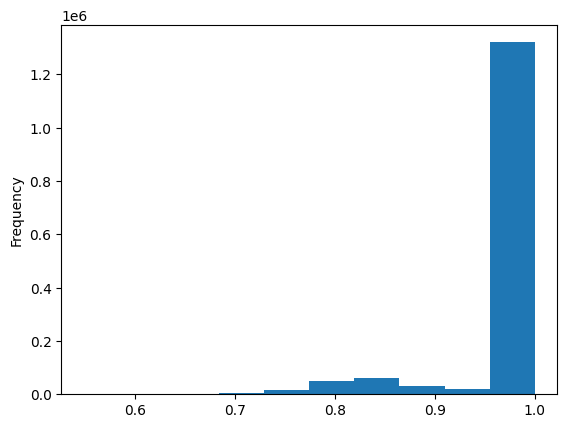

In [153]:
posts_gs['gs_scores'].plot.hist()

Note: users with only 1 posts are very high and have 1 gs scores

248972

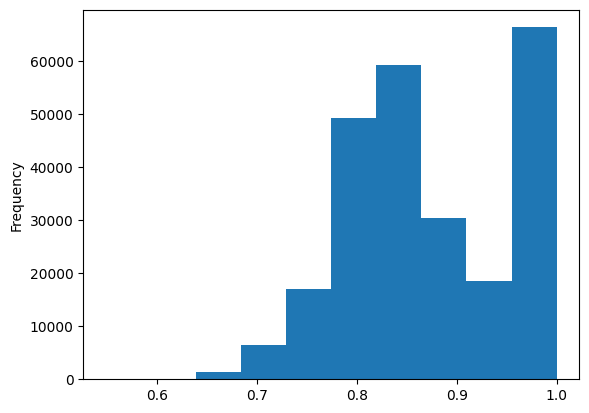

In [163]:
posts_gs[posts_gs['number_of_engagements']!=1]['gs_scores'].plot.hist()
posts_gs[posts_gs['number_of_engagements']!=1].shape[0]

<Axes: xlabel='gs_scores', ylabel='number_of_engagements'>

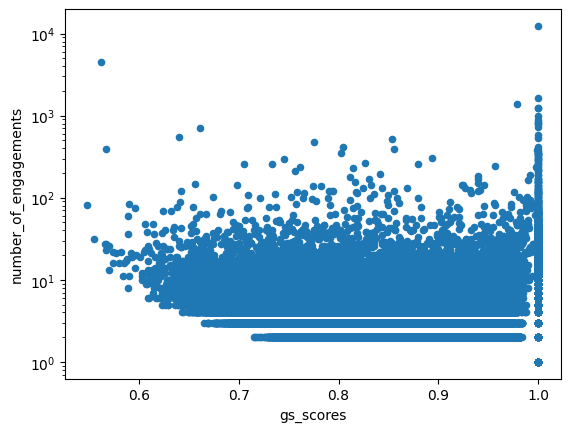

In [165]:
posts_gs.plot.scatter(x='gs_scores',y='number_of_engagements',logy=True)

In [240]:
sentiment_title = pd.read_csv('post_title_sentiments.csv')
comments_sentiment = pd.read_csv('post_comment_sentiments.csv')
post_fields = ['id','author','subreddit','score','created_utc']
posts = pd.read_csv('text_submissions.csv',usecols=post_fields)

C:\Users\Wasimroks\AppData\Local\Temp\ipykernel_22532\3939819383.py:4: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  posts = pd.read_csv('text_submissions.csv',usecols=post_fields)


In [241]:
#filter posts with no authors
posts = posts[(posts['author'] != '[deleted]')]
#parse time data
posts['created_utc'] = pd.to_numeric(posts['created_utc'], errors='coerce')
posts['time'] = pd.to_datetime(posts['created_utc'],utc=True,unit='s')
#drop rows with na
posts = posts.dropna()

Create posts with GS-score of user as a field

In [379]:
posts_1 = posts.merge(posts_gs[['author','gs_scores','number_of_engagements']],on='author')

Posts + gs + comment data 

In [382]:
posts_comments = pd.merge(posts_1,comments_sentiment.loc[:,['neg','neu','pos','compound','link_id']],left_on='id', right_on='link_id',how='left')
posts_comments = posts_comments.groupby('id').agg({'compound': 'mean','neg': 'mean', 'neu': 'mean', 'pos':'mean', 'link_id': 'count'}).reset_index()
posts_comments.columns = ['id', 'avg_compound_sentiment','avg_neg_sentiment','avg_neu_sentiment','avg_pos_sentiment', 'total_comments']
posts_comments['avg_compound_sentiment'].fillna(0, inplace=True)
posts_comments['avg_neg_sentiment'].fillna(0, inplace=True)
posts_comments['avg_neu_sentiment'].fillna(0, inplace=True)
posts_comments['avg_pos_sentiment'].fillna(0, inplace=True)
posts_comments = posts_1.merge(posts_comments,on='id')


In [383]:
posts_comments

,id,author,created_utc,score,subreddit,time,gs_scores,number_of_engagements,avg_compound_sentiment,avg_neg_sentiment,avg_neu_sentiment,avg_pos_sentiment,total_comments
0,t3_npxigk,All_Consuming_Void,1.622564e+09,0.0,BeautyGuruChatter,2021-06-01 16:06:55+00:00,0.815652,3,0.0000,0.0,0.000,0.000,0
1,t3_mly4kr,All_Consuming_Void,1.617787e+09,5.0,tretinoin,2021-04-07 09:13:12+00:00,0.815652,3,0.0000,0.0,0.000,0.000,0
2,t3_i4oyj1,All_Consuming_Void,1.596708e+09,511.0,keto,2020-08-06 09:57:09+00:00,0.815652,3,0.0000,0.0,0.000,0.000,0
3,t3_ltlwai,All_Consuming_Void,1.614424e+09,1.0,SkincareAddiction,2021-02-27 11:06:36+00:00,0.815652,3,0.8268,0.0,0.535,0.465,1
4,t3_nqj6bf,AutoModerator,1.622632e+09,38.0,BeautyGuruChatter,2021-06-02 11:00:21+00:00,0.561905,4522,0.0000,0.0,0.000,0.000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2153032,t3_alji9i,DrummerDKS,1.548894e+09,5.0,personalfinance,2019-01-31 00:16:11+00:00,1.000000,1,0.0000,0.0,0.000,0.000,0
2153033,t3_atcmjf,Geotonics,1.550807e+09,0.0,Fitness,2019-02-22 03:42:47+00:00,1.000000,1,0.0000,0.0,0.000,0.000,0
2153034,t3_adhoet,ScorpionFishCow,1.546868e+09,16.0,PewdiepieSubmissions,2019-01-07 13:30:46+00:00,1.000000,1,0.0000,0.0,0.000,0.000,0
2153035,t3_bec7yr,QuietDirector,1.555531e+09,1.0,trashy,2019-04-17 19:52:42+00:00,1.000000,1,0.0000,0.0,0.000,0.000,0


# GS-Score and submission statistics
Utilize the ratio of submissions in a time frame to see if the user is a actively creating \
Train a model with and without GS-scores to see if active contributors can be identified


### Investigate scores and GS-scores of creators

In [176]:
posts_score = posts_1.copy()

In [177]:
posts_score

,id,author,created_utc,score,subreddit,time,gs_scores,number_of_engagements
0,t3_npxigk,All_Consuming_Void,1.622564e+09,0.0,BeautyGuruChatter,2021-06-01 16:06:55+00:00,0.815652,3
1,t3_mly4kr,All_Consuming_Void,1.617787e+09,5.0,tretinoin,2021-04-07 09:13:12+00:00,0.815652,3
2,t3_i4oyj1,All_Consuming_Void,1.596708e+09,511.0,keto,2020-08-06 09:57:09+00:00,0.815652,3
3,t3_ltlwai,All_Consuming_Void,1.614424e+09,1.0,SkincareAddiction,2021-02-27 11:06:36+00:00,0.815652,3
4,t3_nqj6bf,AutoModerator,1.622632e+09,38.0,BeautyGuruChatter,2021-06-02 11:00:21+00:00,0.561905,4522
...,...,...,...,...,...,...,...,...
2153032,t3_alji9i,DrummerDKS,1.548894e+09,5.0,personalfinance,2019-01-31 00:16:11+00:00,1.000000,1
2153033,t3_atcmjf,Geotonics,1.550807e+09,0.0,Fitness,2019-02-22 03:42:47+00:00,1.000000,1
2153034,t3_adhoet,ScorpionFishCow,1.546868e+09,16.0,PewdiepieSubmissions,2019-01-07 13:30:46+00:00,1.000000,1
2153035,t3_bec7yr,QuietDirector,1.555531e+09,1.0,trashy,2019-04-17 19:52:42+00:00,1.000000,1


<Axes: xlabel='gs_scores', ylabel='number_of_engagements'>

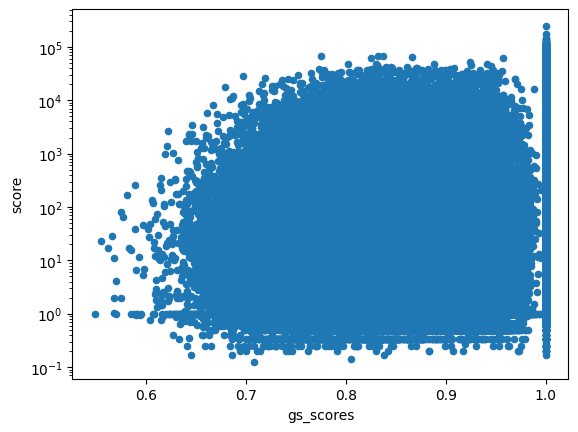

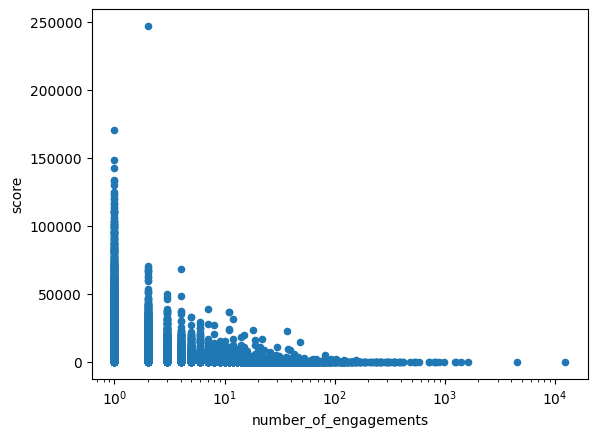

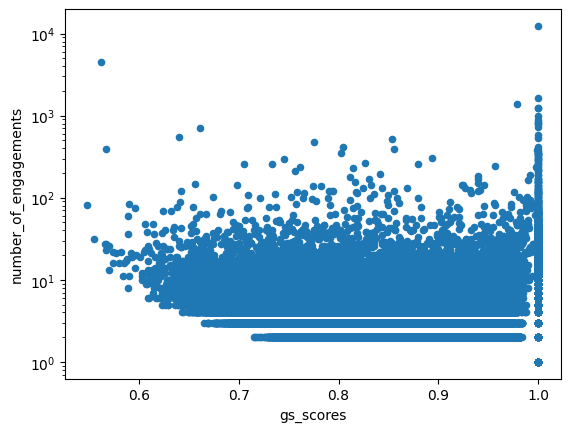

In [470]:
posts_score.groupby('author').mean('score').plot.scatter(x='gs_scores',y='score',logy=True)
posts_score.groupby('author').mean('score').plot.scatter(x='number_of_engagements',y='score',logx=True)
posts_gs.plot.scatter(x='gs_scores',y='number_of_engagements',logy=True)

Scores and number of engagements seems to be inversely proportional

### GS-scores vs Total Comments

<Axes: xlabel='gs_scores', ylabel='total_comments'>

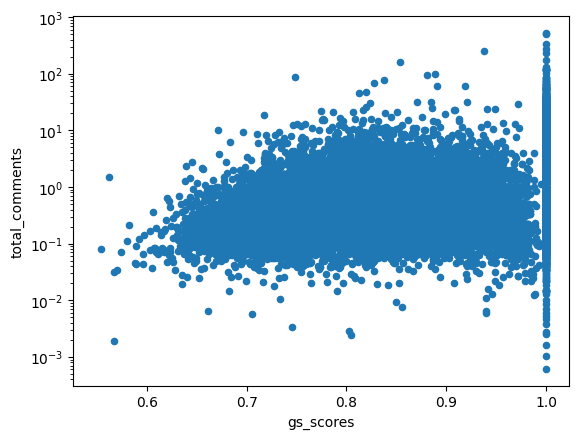

In [221]:
posts_comments.groupby('author').mean('total_comments').plot.scatter(x='gs_scores',y='total_comments',logy=True)

### GS-scores vs Post Frequency

In [286]:
temp = posts_1.groupby('author').agg({'time': ['min', 'max'],'number_of_engagements':'first','gs_scores':'first'})
temp['time_difference'] = (temp['time']['max'] - temp['time']['min']).dt.days
post_freq = temp[temp['time_difference']>0]
post_freq['post_freq'] = post_freq['number_of_engagements']['first'] / post_freq['time_difference']

C:\Users\Wasimroks\AppData\Local\Temp\ipykernel_22532\731555639.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post_freq['post_freq'] = post_freq['number_of_engagements']['first'] / post_freq['time_difference']


<Axes: xlabel='gs_scores', ylabel='post_freq'>

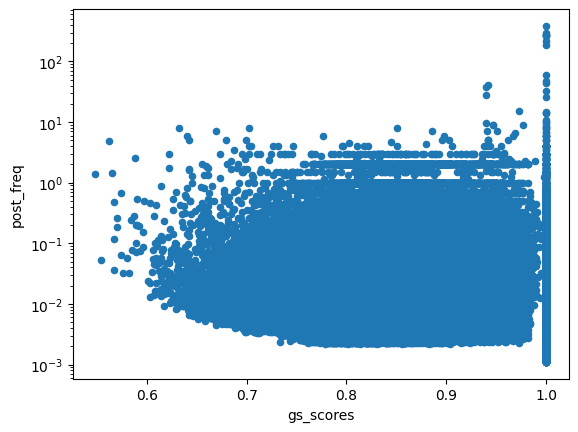

In [561]:
post_freq.plot.scatter(x='gs_scores',y='post_freq',logy=True)

## GS-scores of Elite Posters 

User GS-Score's relation Post Submission Rate and Avg Rating
User GS-Score and Sentiment of their comments
Community GS-Score's and Top Post submitters [Elite Posters]
Compare Elite posters (top 5% posts) with community GS-scores, the original paper suggested elite commenters are generalists, is it also true for posters? 

In [352]:
#calculate community gs-scores
# Group by 'subreddit' and calculate the mean gs_score for each subreddit weighted by number of contributions
community_gs_scores = posts_1.groupby('subreddit')['gs_scores'].mean()

In [388]:
size_gs = posts_1.merge(community_gs_scores,on='subreddit')
size_gs = size_gs.groupby('subreddit').aggregate({'gs_scores_y':'first','id':'count'})
size_gs.columns = ['gs_scores','community_size']

,gs_scores,community_size
subreddit,,
1200isplenty,0.959277,483
13ReasonsWhy,0.953742,145
13or30,0.936180,164
195,0.957776,370
196,0.927062,1236
...,...,...
yugioh,0.949348,884
zelda,0.935952,713
zen,0.974385,112


<Axes: xlabel='gs_scores', ylabel='community_size'>

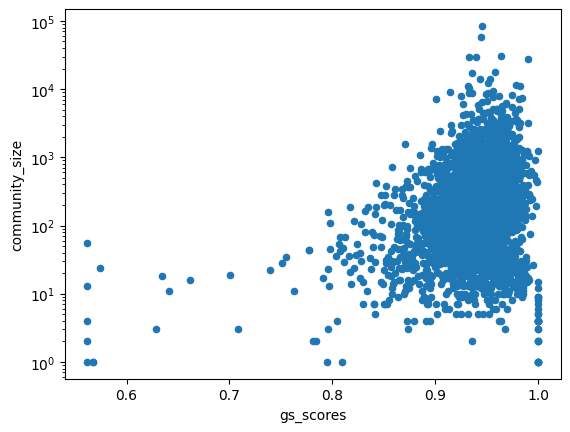

In [390]:
size_gs.plot.scatter('gs_scores','community_size',logy=True)

Calculate elite posters and their GS scores per community

In [353]:
avg_score_per_post = posts_1.groupby(['subreddit', 'author'])['score'].mean().reset_index(name='avg_score_per_post')

In [354]:
avg_score_per_post['rank'] = avg_score_per_post.groupby('subreddit')['avg_score_per_post'].rank(ascending=False)
top_5_percent_authors = avg_score_per_post[avg_score_per_post['rank'] <= avg_score_per_post.groupby('subreddit')['rank'].transform(lambda x: x.quantile(0.05))]
filtered_df = posts_1[posts_1.set_index(['subreddit', 'author']).index.isin(top_5_percent_authors.set_index(['subreddit', 'author']).index)]

In [355]:
elite_gs_scores = filtered_df.groupby('subreddit')['gs_scores'].mean()

In [356]:

result_df = pd.concat([community_gs_scores, elite_gs_scores], axis=1)
result_df.columns = ['community_gs', 'elite_gs']

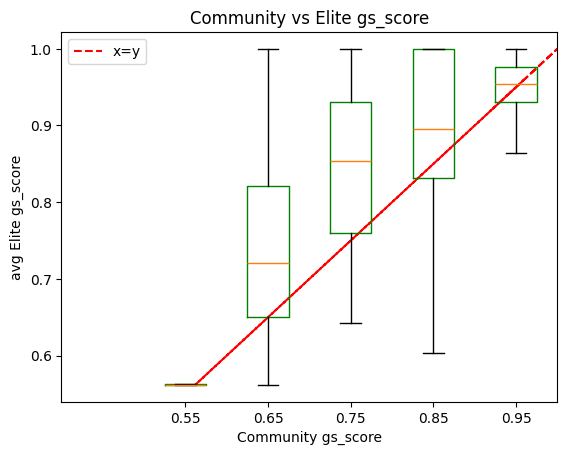

In [375]:

# Plot the line x=y
plt.plot(result_df['community_gs'], result_df['community_gs'], color='red', linestyle='--', label='x=y')
# Add labels and title
plt.xlabel('Community gs_score')
plt.ylabel('avg Elite gs_score')
plt.title('Community vs Elite gs_score')
def generate_box_plots(pos):
    community_gs_box_data = result_df[(result_df['community_gs'] >= (pos-0.025)) & (result_df['community_gs'] <= (pos+0.025))]['elite_gs']
    plt.boxplot([community_gs_box_data], positions=[pos], widths=0.05, showfliers=False, boxprops=dict(color='green'))
for i in np.arange(0.55,1.1,0.1):
    generate_box_plots(i)
plt.legend()
plt.xlim(0.4, 1)
# Show the plot
plt.show()

As you can see avg elite gs_scores is >= community gs_scores \
meaning that elites posters are more successful within the community \
This is in contrast to elite commentors in the original paper \
A conclusion that can be made is that posting is a more skillfull / creative, thus a more specialized person is more likely to have the know how to make a better post than a generalist

In [295]:
posts_1

,id,author,created_utc,score,subreddit,time,gs_scores,number_of_engagements
0,t3_npxigk,All_Consuming_Void,1.622564e+09,0.0,BeautyGuruChatter,2021-06-01 16:06:55+00:00,0.815652,3
1,t3_mly4kr,All_Consuming_Void,1.617787e+09,5.0,tretinoin,2021-04-07 09:13:12+00:00,0.815652,3
2,t3_i4oyj1,All_Consuming_Void,1.596708e+09,511.0,keto,2020-08-06 09:57:09+00:00,0.815652,3
3,t3_ltlwai,All_Consuming_Void,1.614424e+09,1.0,SkincareAddiction,2021-02-27 11:06:36+00:00,0.815652,3
4,t3_nqj6bf,AutoModerator,1.622632e+09,38.0,BeautyGuruChatter,2021-06-02 11:00:21+00:00,0.561905,4522
...,...,...,...,...,...,...,...,...
2153032,t3_alji9i,DrummerDKS,1.548894e+09,5.0,personalfinance,2019-01-31 00:16:11+00:00,1.000000,1
2153033,t3_atcmjf,Geotonics,1.550807e+09,0.0,Fitness,2019-02-22 03:42:47+00:00,1.000000,1
2153034,t3_adhoet,ScorpionFishCow,1.546868e+09,16.0,PewdiepieSubmissions,2019-01-07 13:30:46+00:00,1.000000,1
2153035,t3_bec7yr,QuietDirector,1.555531e+09,1.0,trashy,2019-04-17 19:52:42+00:00,1.000000,1


# GS-Score and Sentiment relationship
Investigate and study relationship between sentiment and GS-scores \
Utilize Vader to study basic emotions such as positive, negative, neutral \
Visualize as a graph of GS-score vs each sentiment \
Hypothesis to test: Can GS-scores of communities contribute to their emotions and strenght? \
                    Are specialists more likely to be enthusiastic, since they are more picky?

### Average comment sentiment vs gs-scores

In [457]:
posts_comm_gt1 = posts_comments.loc[posts_comments['total_comments']>0,:]
posts_comm_gt1 = posts_comm_gt1.groupby('author').aggregate({'avg_pos_sentiment':'mean','gs_scores':'first'})


<Axes: xlabel='gs_scores', ylabel='avg_pos_sentiment'>

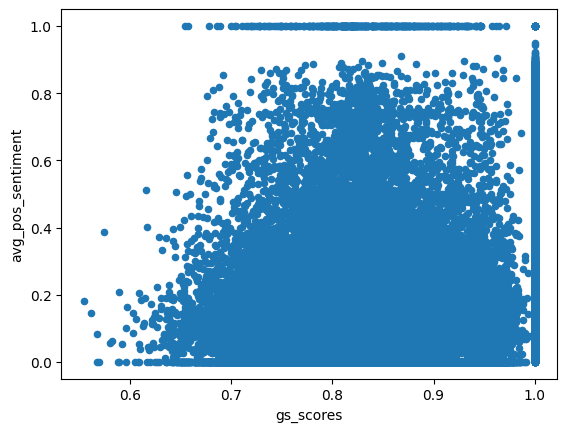

In [458]:
posts_comm_gt1.plot.scatter('gs_scores','avg_pos_sentiment')

user's gs vs compound sentiment is not useful

In [459]:
temp = posts_comments.loc[posts_comments['total_comments']>0,:]
temp = temp.groupby('subreddit').aggregate({'avg_compound_sentiment':'mean','avg_neg_sentiment':'mean'
                                            ,'avg_pos_sentiment':'mean','avg_neu_sentiment':'mean'})
temp = temp.merge(community_gs_scores.reset_index(),on='subreddit')
temp = temp.set_index('subreddit')

<Axes: xlabel='gs_scores', ylabel='avg_pos_sentiment'>

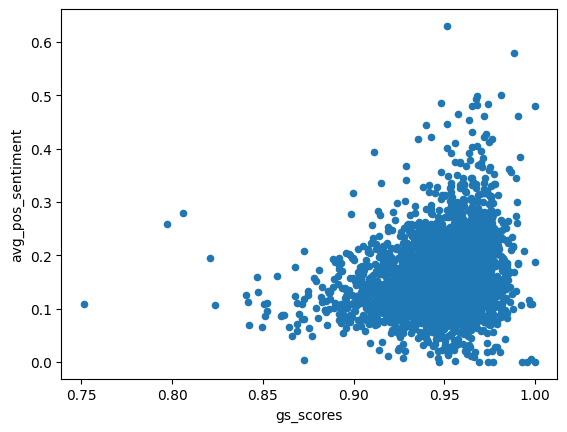

In [460]:
temp.plot.scatter('gs_scores','avg_pos_sentiment')

In [461]:
temp['gs_scores'].describe()

count    3182.000000
mean        0.947537
std         0.022577
min         0.751378
25%         0.936279
50%         0.951048
75%         0.962732
max         1.000000
Name: gs_scores, dtype: float64

C:\Users\Wasimroks\AppData\Local\Temp\ipykernel_22532\49473767.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sentiment_groups = temp.groupby(pd.cut(temp['gs_scores'], [0.7,0.936,0.951,0.962,1.0])).mean()


<Axes: xlabel='gs_scores'>

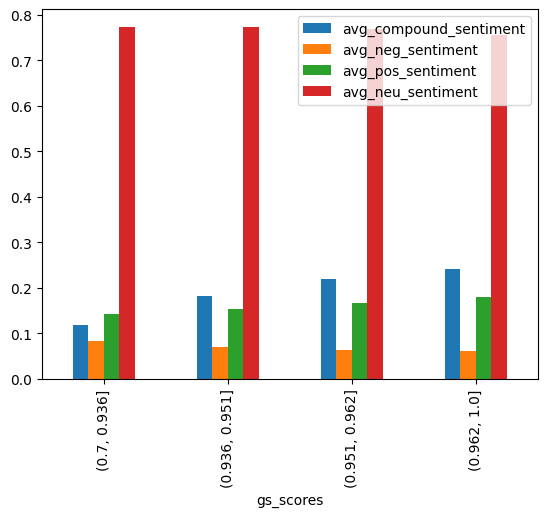

In [466]:
sentiment_groups = temp.groupby(pd.cut(temp['gs_scores'], [0.7,0.936,0.951,0.962,1.0])).mean()
sentiment_groups[['avg_compound_sentiment','avg_neg_sentiment','avg_pos_sentiment','avg_neu_sentiment']].plot.bar()

In [467]:
sentiment_groups

,avg_compound_sentiment,avg_neg_sentiment,avg_pos_sentiment,avg_neu_sentiment,gs_scores
gs_scores,,,,,
"(0.7, 0.936]",0.118537,0.082475,0.141126,0.773485,0.917273
"(0.936, 0.951]",0.181046,0.070245,0.153998,0.772151,0.944124
"(0.951, 0.962]",0.219658,0.062838,0.167056,0.767909,0.956529
"(0.962, 1.0]",0.240096,0.061953,0.180432,0.755036,0.970843


In [570]:
temp[['avg_pos_sentiment','gs_scores']].corr()

,avg_pos_sentiment,gs_scores
avg_pos_sentiment,1.000000,0.220888
gs_scores,0.220888,1.000000


Split into 25th percentile , 25th to 50th percentile, and 50th to 75th , and >75th percentile
It seems that the positive responses (discussion) within a community increases with gs_scores \
Thus more specialized communities have slightly higher positive responses within them \
However most of the comments are neutral

### Average title sentiment vs gs-scores

In [486]:
comm_sent_title = posts_1.merge(sentiment_title,on='id').groupby('subreddit').aggregate({
    'pos':'mean','neu':'mean','neg':'mean','compound':'mean'
})
comm_sent_title = comm_sent_title.merge(community_gs_scores.reset_index(),on='subreddit').set_index('subreddit')

In [487]:
comm_sent_title['gs_scores'].describe()

count    3182.000000
mean        0.947537
std         0.022577
min         0.751378
25%         0.936279
50%         0.951048
75%         0.962732
max         1.000000
Name: gs_scores, dtype: float64

C:\Users\Wasimroks\AppData\Local\Temp\ipykernel_22532\3971119280.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  title_groups = comm_sent_title.groupby(pd.cut(comm_sent_title['gs_scores'], [0.7,0.936,0.951,0.962,1.0])).mean()


<Axes: xlabel='gs_scores'>

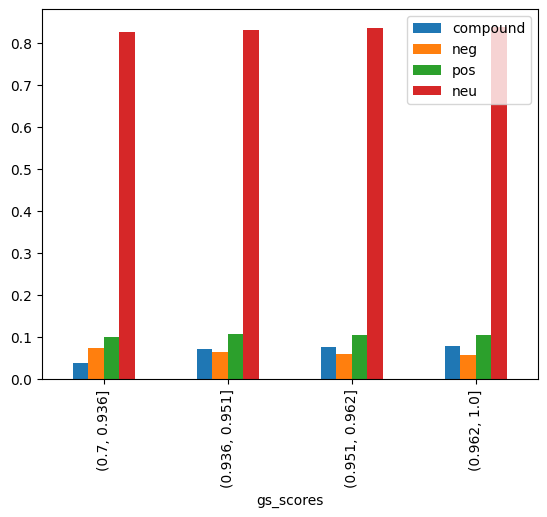

In [488]:
title_groups = comm_sent_title.groupby(pd.cut(comm_sent_title['gs_scores'], [0.7,0.936,0.951,0.962,1.0])).mean()
title_groups[['compound','neg','pos','neu']].plot.bar()

In [489]:
title_groups

,pos,neu,neg,compound,gs_scores
gs_scores,,,,,
"(0.7, 0.936]",0.099821,0.825551,0.073322,0.038405,0.917273
"(0.936, 0.951]",0.107465,0.828770,0.062425,0.069783,0.944124
"(0.951, 0.962]",0.104506,0.835552,0.058826,0.074576,0.956529
"(0.962, 1.0]",0.104659,0.837571,0.056644,0.079033,0.970843


Title sentiment doesn't vary much with gs_scores for communities \
Use comment sentiment instead for sentiment analysis

## Use social dimensions to categorize community wide specialization


Create social dimenstions of each community \
Get community GS scores of posters \
find optimum number of clusters using elbow-method


In [499]:
social_dims = pd.read_csv('scores.csv')
comm_gs = community_gs_scores.reset_index()
social_dims = social_dims.set_index('community')

use elbow method to find the optimum number of clusters

c:\Users\Wasimroks\.pyenv\pyenv-win\versions\3.11.3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Wasimroks\.pyenv\pyenv-win\versions\3.11.3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Wasimroks\.pyenv\pyenv-win\versions\3.11.3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Wasimroks\.pyenv\pyenv-win\versions\3.11.3\Lib\site-packages\sklearn\cluster\_kmeans.

<Axes: xlabel='k'>

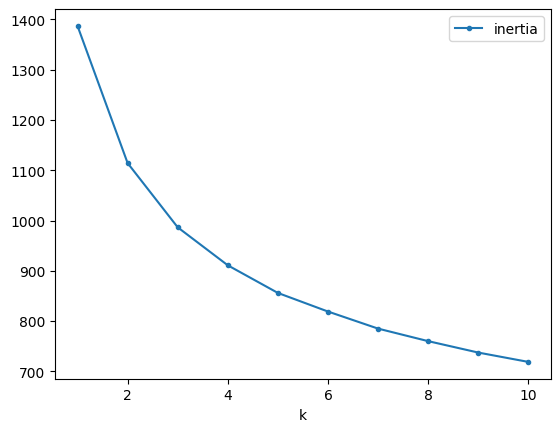

In [493]:
from sklearn.cluster import KMeans
K = range(1, 10+1)
inertias = []
n_clusters= []
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k,random_state=0).fit(social_dims)
    inertias.append(kmeanModel.inertia_)
    n_clusters.append(k)
elbow = pd.DataFrame(inertias,columns=['inertia'])
elbow['k']=pd.Series(n_clusters)
elbow.plot(style='.-',x='k',y='inertia')

use n = 4 to be safe

Visualize embeddings via social dimensions, and cluster using kmeans and pca

In [500]:
kmeans = KMeans(n_clusters=4,random_state=0).fit(social_dims)
cluster_data = pd.DataFrame(kmeans.labels_,index=social_dims.index,columns=['cluster'])

c:\Users\Wasimroks\.pyenv\pyenv-win\versions\3.11.3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [504]:
import plotly.express as px
from sklearn.decomposition import PCA
pca_embeddings = PCA().fit_transform(social_dims)
pca_embeddings = pd.DataFrame(pca_embeddings,index=social_dims.index)

In [505]:
kmeans_pca = cluster_data.join(pca_embeddings)
px.scatter(kmeans_pca,x=0,y=1,color='cluster',labels={"cluster":"Cluster no."}).show()

Clustering the subreddits by social dimensions group them into 4 distinct clusters

In [506]:
social_dims = social_dims.join(cluster_data)


In [509]:
social_dims = social_dims.reset_index()

In [513]:
social_dims = social_dims.rename(columns={"community":"subreddit"})

In [545]:
social_gs = community_gs_scores.reset_index().merge(social_dims,on="subreddit").drop(columns=['subreddit'])

In [546]:
social_gs.groupby('cluster').mean()

,gs_scores,age,age B,age neutral,affluence,gender,gender B,gender neutral,partisan B,partisan B neutral,partisan,partisan neutral,edginess,sociality,time
cluster,,,,,,,,,,,,,,,
0,0.937511,0.133561,0.110382,0.485199,0.124129,0.015319,0.014241,0.463916,-0.001842,0.414839,-0.014981,0.442338,0.018049,-0.084459,-0.033545
1,0.954034,0.060631,0.034078,0.500598,0.091933,0.192802,0.217137,0.534731,-0.024877,0.409919,-0.051959,0.420139,-0.052275,0.071989,0.053568
2,0.952540,-0.139609,-0.115660,0.447830,-0.005878,0.030904,0.084478,0.385517,0.041355,0.378992,0.038160,0.382719,0.004210,0.093442,0.127856
3,0.945133,0.032420,0.048605,0.445369,0.059519,-0.023133,-0.024520,0.407552,0.090793,0.423662,0.029915,0.409887,-0.009453,0.024908,0.120751


Are certain social clusters of a higher GS-score?
group the clusters and find average gs_scores. find average social dims of each cluster

The major clusters don't tell us much about effect of gs_scores

In [547]:
social_gs['gs_scores'].describe()

count    3182.000000
mean        0.947537
std         0.022577
min         0.751378
25%         0.936279
50%         0.951048
75%         0.962732
max         1.000000
Name: gs_scores, dtype: float64

In [562]:
print(l)

['age', 'age B', 'age neutral', 'affluence', 'gender', 'gender B', 'gender neutral', 'partisan B', 'partisan B neutral', 'partisan', 'partisan neutral', 'edginess', 'sociality', 'time']


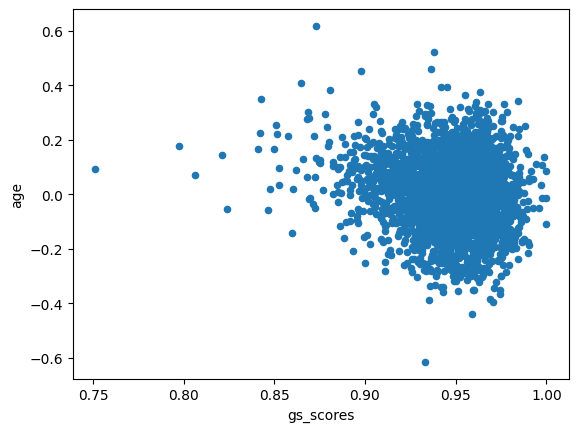

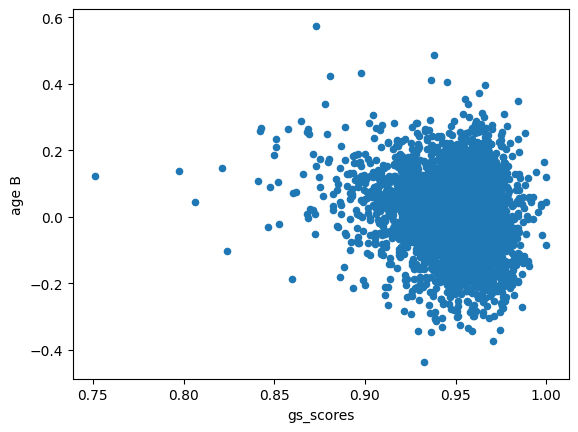

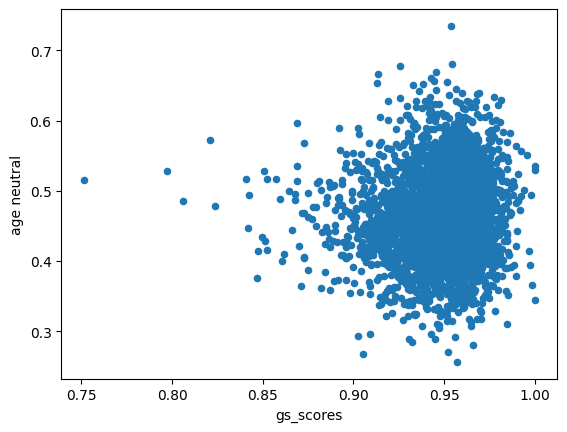

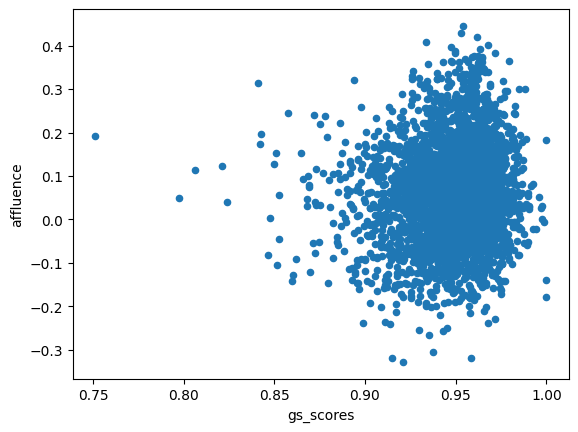

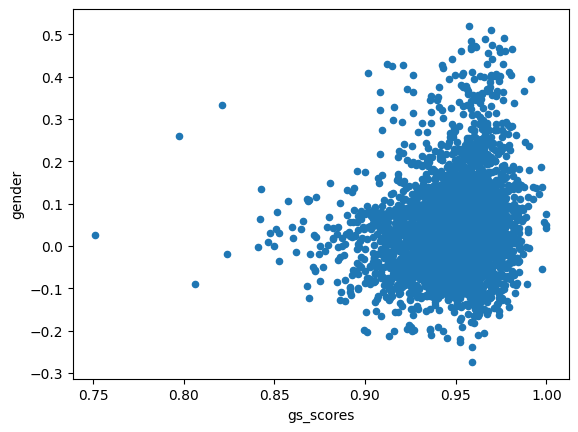

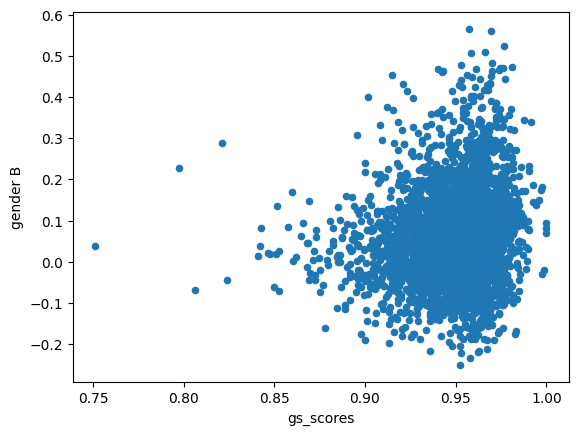

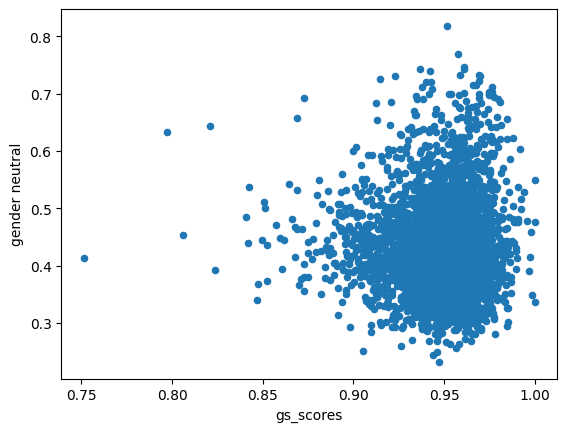

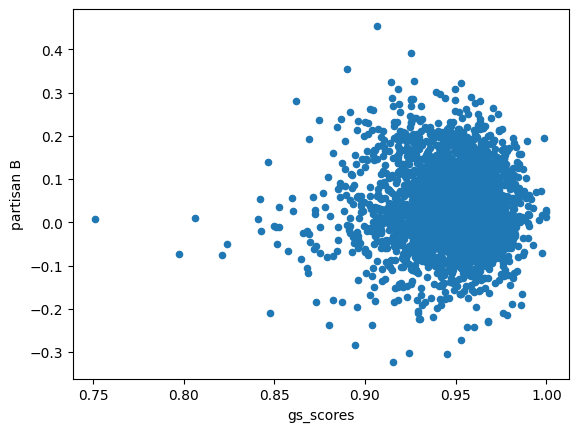

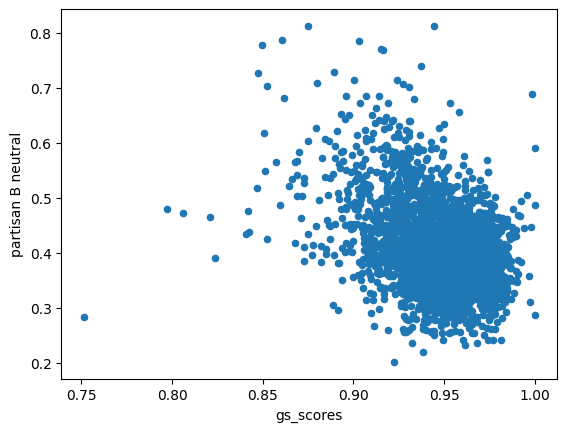

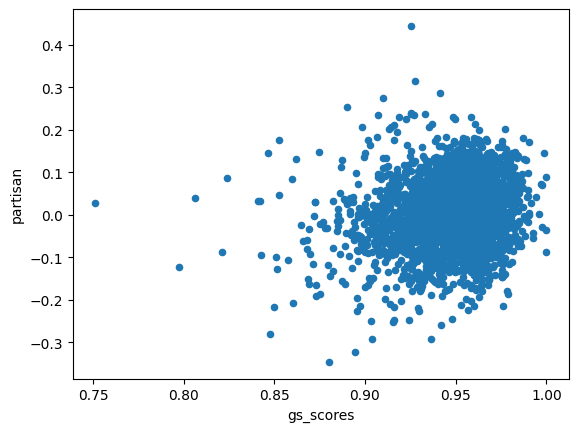

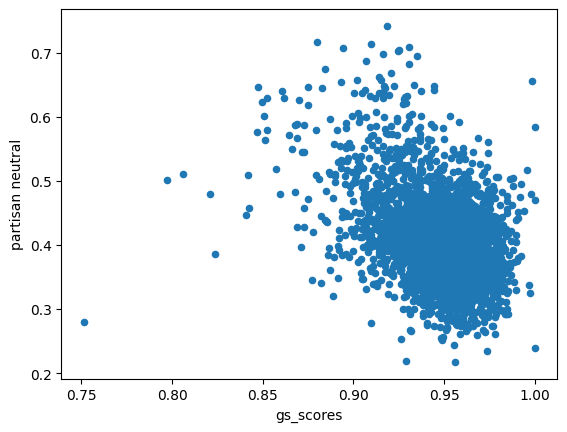

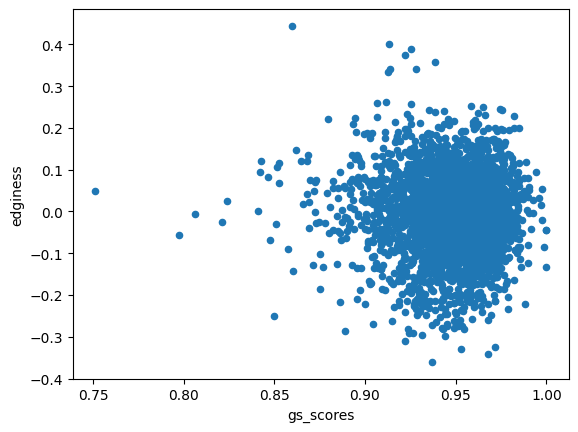

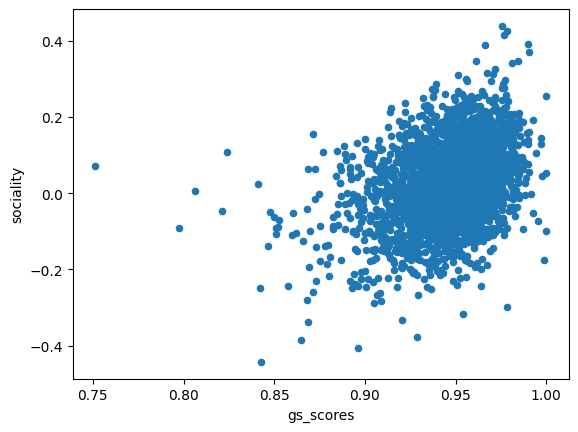

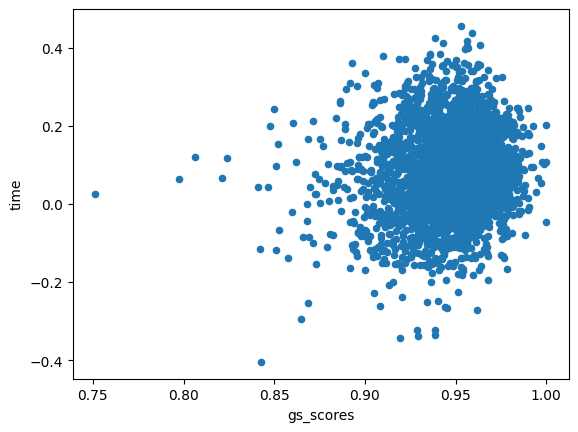

In [559]:
l = social_gs.columns.to_list()
l.remove('cluster')
l.remove('gs_scores')
for col in l:
    social_gs.plot.scatter('gs_scores',col)

C:\Users\Wasimroks\AppData\Local\Temp\ipykernel_22532\659355178.py:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



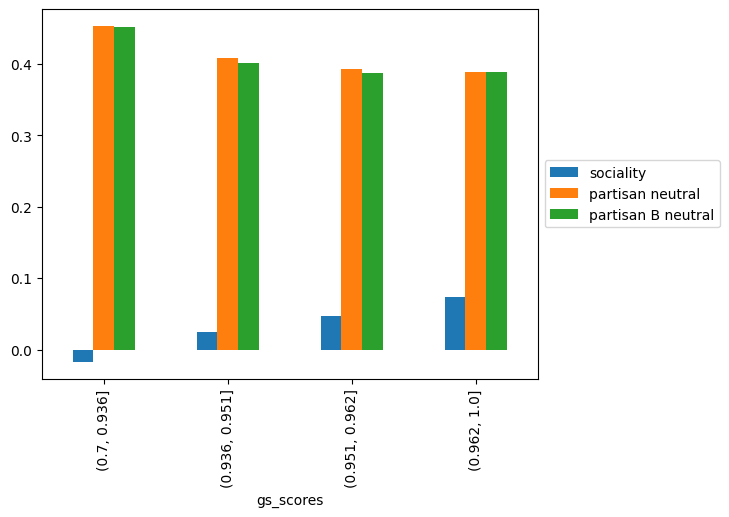

In [563]:
social_groups = social_gs.groupby(pd.cut(social_gs['gs_scores'], [0.7,0.936,0.951,0.962,1.0])).mean()
social_groups[['sociality','partisan neutral','partisan B neutral']].plot.bar().legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

In [564]:
social_groups[['sociality','partisan neutral','partisan B neutral']]

,sociality,partisan neutral,partisan B neutral
gs_scores,,,
"(0.7, 0.936]",-0.017214,0.452758,0.450972
"(0.936, 0.951]",0.024542,0.408416,0.400206
"(0.951, 0.962]",0.047196,0.392273,0.386893
"(0.962, 1.0]",0.073651,0.388882,0.387812


In [565]:
social_gs[['sociality','gs_scores']].corr()

,sociality,gs_scores
sociality,1.000000,0.360378
gs_scores,0.360378,1.000000


	- name: sociality
	  seeds:
		- [nyc, nycmeetups]
		- [law, LSAT]
		- [paris, travelpartners]
		- [sanfrancisco, SFr4r]
		- [boston, bostonhousing]
		- [Zappa, stonerrock]
		- [conan, NewGirl]
		- [ClashOfClans, EverWing]
		- [answers, findareddit]
		- [xbox360, XboxOneGamers]
These were used to make sociality